# Final Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* And, as a bonus challenge, a neural network using Keras.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?

Below I've set up an outline of a notebook for this project, with some guidance and hints. If you're up for a real challenge, try doing this project from scratch in a new, clean notebook!


## Let's begin: prepare your data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe (hint: use read_csv) and take a look at it.

In [1]:
import pandas as pd

data = pd.read_csv("mammographic_masses.data.txt")
data.head()

,5,67,3,5.1,3.1,1
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0


Make sure you use the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [2]:
features_all =  ['BI_RADS', 'age', 'shape', 'margin', 'density', 'severity']
features = ['age', 'shape', 'margin', 'density']
data = pd.read_csv("mammographic_masses.data.txt", na_values = ['?'], names = features_all)
data.head()

,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.

In [3]:
data.describe()

,BI_RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().

In [4]:
data.dropna(inplace = True)
data.describe()

,BI_RADS,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663,0.485542
std,1.888371,14.671782,1.242361,1.567175,0.350936,0.500092
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [5]:
import numpy as np
feature_data = np.array(data[features])

feature_class = np.array(data['severity'])
feature_data[0]

array([67.,  3.,  5.,  3.])

Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [6]:
from sklearn import preprocessing
feature_data = preprocessing.StandardScaler().fit_transform(feature_data)
feature_data[0]

array([0.7650629 , 0.17563638, 1.39618483, 0.24046607])

## Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [7]:
import numpy
from sklearn.model_selection import train_test_split

numpy.random.seed(1234)

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(feature_data, feature_class, train_size=0.75, random_state=1)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Now create a DecisionTreeClassifier and fit it to your training data.

In [8]:
from sklearn import tree
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(training_inputs,training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Display the resulting decision tree.

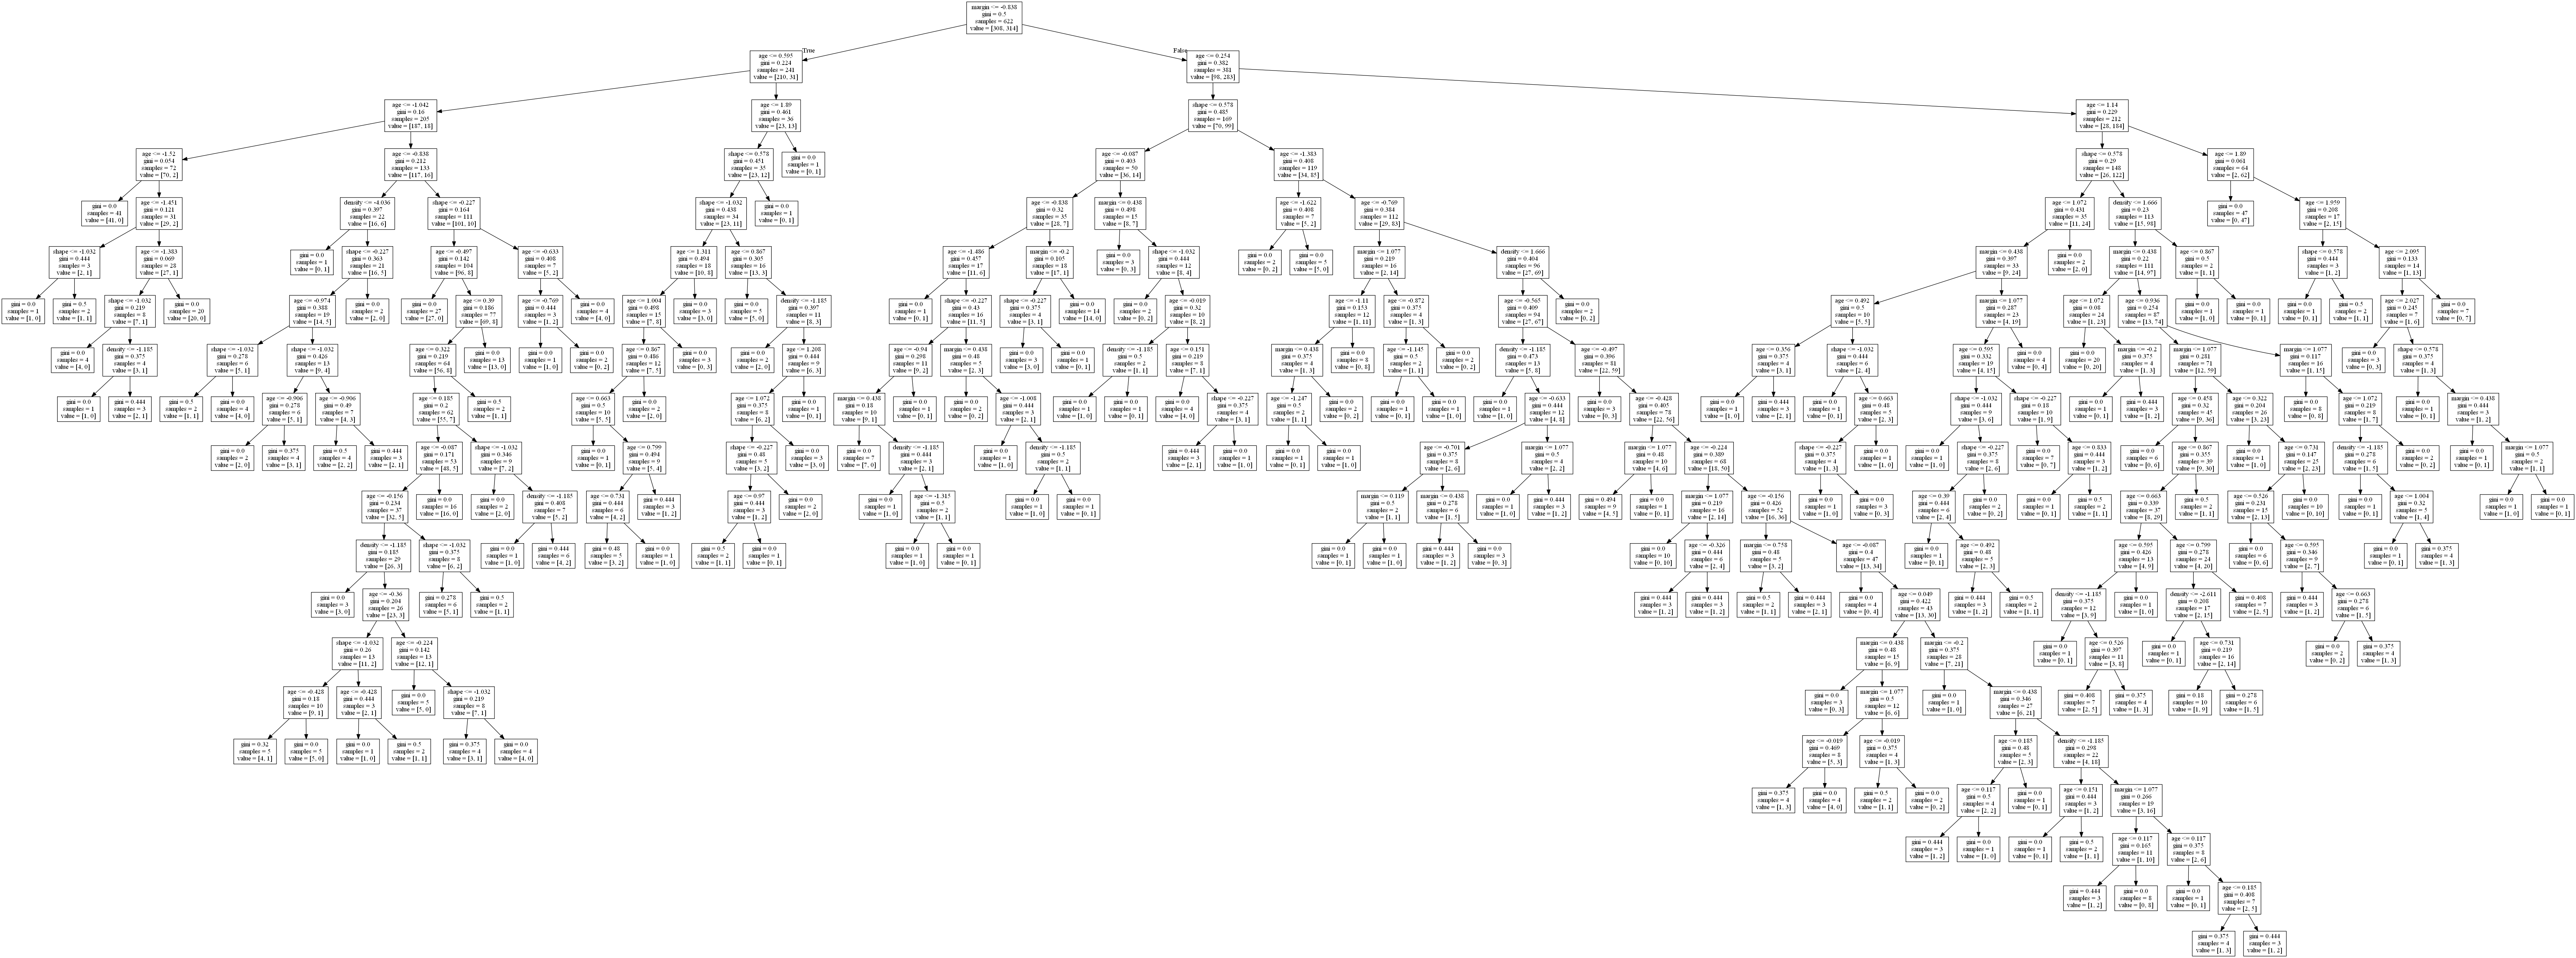

In [9]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus
dot_data = StringIO()  
tree.export_graphviz(decision_tree, out_file=dot_data,  
                         feature_names=features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

Measure the accuracy of the resulting decision tree model using your test data.

In [10]:
decision_tree.score(testing_inputs,testing_classes)

0.7403846153846154

Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10). Hint: use model_selection.cross_val_score

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(decision_tree, testing_inputs, testing_classes,cv=10)

array([0.71428571, 0.57142857, 0.71428571, 0.71428571, 0.57142857,
       0.71428571, 0.71428571, 0.57142857, 0.71428571, 0.57894737])

Now try a RandomForestClassifier instead. Does it perform better?

In [12]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier()
randomForest.fit(training_inputs,training_classes)
print (randomForest.score(testing_inputs,testing_classes))
print (cross_val_score(randomForest, testing_inputs, testing_classes,cv=10))

0.75
[0.76190476 0.57142857 0.66666667 0.85714286 0.52380952 0.76190476
 0.76190476 0.61904762 0.71428571 0.63157895]


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [13]:
from sklearn import svm, datasets
svmModel = svm.SVC(kernel = 'linear')
svmModel.fit(training_inputs,training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [14]:
svmModel.score(testing_inputs,testing_classes)

0.7692307692307693

In [15]:
cross_val_score(svmModel, testing_inputs, testing_classes, cv=10)

array([0.9047619 , 0.76190476, 0.76190476, 0.80952381, 0.52380952,
       0.71428571, 0.80952381, 0.76190476, 0.76190476, 0.68421053])

## KNN
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [16]:
from sklearn import neighbors

def getKnnModel(training_inputs, training_classes, testing_inputs, testing_classes):
    maxScore = 0
    k = 0
    knnModelOutPut = neighbors.KNeighborsClassifier()
    for i in range(1,51):
            knnModel = neighbors.KNeighborsClassifier(n_neighbors=i)
            knnModel.fit(training_inputs,training_classes)
            tempScore = knnModel.score(testing_inputs,testing_classes)
            print("hyper-parameter neighbors = ", i," and  score = ", tempScore)
            if(tempScore>maxScore):
                maxScore = tempScore
                k = i
                knnModelOutPut = knnModel
    return knnModelOutPut

Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

In [17]:
knnModel = getKnnModel(training_inputs, training_classes, testing_inputs, testing_classes)
print ("best score is ", knnModel.score(testing_inputs,testing_classes), "and neighbours are",knnModel.get_params()['n_neighbors'] )
cross_val_score(knnModel, testing_inputs, testing_classes, cv=10)

hyper-parameter neighbors =  1  and  score =  0.7307692307692307
hyper-parameter neighbors =  2  and  score =  0.7451923076923077
hyper-parameter neighbors =  3  and  score =  0.7548076923076923
hyper-parameter neighbors =  4  and  score =  0.7403846153846154
hyper-parameter neighbors =  5  and  score =  0.7740384615384616
hyper-parameter neighbors =  6  and  score =  0.7596153846153846
hyper-parameter neighbors =  7  and  score =  0.7836538461538461
hyper-parameter neighbors =  8  and  score =  0.7740384615384616
hyper-parameter neighbors =  9  and  score =  0.7788461538461539
hyper-parameter neighbors =  10  and  score =  0.7740384615384616
hyper-parameter neighbors =  11  and  score =  0.7644230769230769
hyper-parameter neighbors =  12  and  score =  0.7644230769230769
hyper-parameter neighbors =  13  and  score =  0.7451923076923077
hyper-parameter neighbors =  14  and  score =  0.7451923076923077
hyper-parameter neighbors =  15  and  score =  0.7451923076923077
hyper-parameter nei

array([0.9047619 , 0.66666667, 0.80952381, 0.76190476, 0.52380952,
       0.71428571, 0.80952381, 0.66666667, 0.71428571, 0.78947368])

## Naive Bayes

Now try naive_bayes.MultinomialNB. How does its accuracy stack up? Hint: you'll need to use MinMaxScaler to get the features in the range MultinomialNB requires.

In [18]:
from sklearn import naive_bayes
from sklearn.preprocessing import MinMaxScaler

multinomialModel = naive_bayes.MultinomialNB()
scaledTrain =  MinMaxScaler()
scaledTest = MinMaxScaler()
training_inputs_scaled = scaledTrain.fit_transform(training_inputs)
testing_inputs_scaled = scaledTest.fit_transform(testing_inputs)
multinomialModel.fit(training_inputs_scaled,training_classes)
multinomialModel.score(testing_inputs_scaled,testing_classes)
cross_val_score(multinomialModel, testing_inputs_scaled, testing_classes, cv=10)

array([0.76190476, 0.66666667, 0.76190476, 0.66666667, 0.57142857,
       0.57142857, 0.57142857, 0.76190476, 0.57142857, 0.68421053])

## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

In [19]:
def SVMModelParameter(para):
    svmModel = svm.SVC(kernel = para)
    svmModel.fit(training_inputs,training_classes)
    print(para," results in a score of: ", svmModel.score(testing_inputs,testing_classes))
    print(para, " cross val score is: ", cross_val_score(svmModel, testing_inputs, testing_classes, cv=10))
    return svmModel

In [20]:
SVMModelParameter('rbf')

rbf  results in a score of:  0.7788461538461539
rbf  cross val score is:  [0.9047619  0.61904762 0.76190476 0.71428571 0.52380952 0.76190476
 0.85714286 0.71428571 0.76190476 0.68421053]


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [21]:
SVMModelParameter('sigmoid')

sigmoid  results in a score of:  0.7019230769230769
sigmoid  cross val score is:  [0.9047619  0.71428571 0.80952381 0.76190476 0.52380952 0.71428571
 0.76190476 0.71428571 0.80952381 0.78947368]


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [22]:
SVMModelParameter('linear')

linear  results in a score of:  0.7692307692307693
linear  cross val score is:  [0.9047619  0.76190476 0.76190476 0.80952381 0.52380952 0.71428571
 0.80952381 0.76190476 0.76190476 0.68421053]


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [23]:
SVMModelParameter('poly')

poly  results in a score of:  0.75
poly  cross val score is:  [0.9047619  0.66666667 0.71428571 0.76190476 0.66666667 0.71428571
 0.76190476 0.85714286 0.76190476 0.73684211]


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

## Logistic Regression

We've tried all these fancy techniques, but fundamentally this is just a binary classification problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [24]:
import statsmodels.api as sm
logisticModel = sm.OLS(training_classes, training_inputs_scaled).fit()
#TODO revist

In [25]:
logisticModel.predict(testing_inputs_scaled)

array([ 0.14067146,  0.40420277,  0.67844914,  0.17746929,  0.63245186,
        0.16826983,  0.19261528,  0.84742461,  0.18341583,  0.68695697,
        0.39826323,  0.96037936,  0.79735044,  0.83822515,  0.54371022,
        0.00862617, -0.05251711,  0.94861862, -0.1169133 ,  0.68357171,
        0.53777068,  0.80061035,  0.70604751,  0.85918535,  0.66261151,
        0.20507465,  0.76719079,  0.73703114,  0.0486769 ,  0.26947085,
        0.93941917,  0.54965676, -0.08931494,  0.15907037,  0.80398861,
        0.7462306 ,  0.25106493,  0.96294064,  0.64095969,  0.92358154,
        0.80398861,  0.75799133,  0.19074564,  0.16501692,  0.6593586 ,
        1.04981264,  0.21427411,  0.65085078,  0.74879188,  0.83822515,
        0.31220821,  0.40094985,  0.61730587,  0.22346656,  0.07033573,
        1.1418072 ,  0.83414826,  0.0486769 ,  0.52856422,  0.52531131,
        0.26026439,  1.10500937,  0.50947368,  0.29706221,  0.75799133,
        0.2786703 ,  0.33980658,  0.18666874,  0.76055261,  0.70

In [26]:
testing_classes

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1], dtype=int64)

## Neural Networks

As a bonus challenge, let's see if an artificial neural network can do even better. You can use Keras to set up a neural network with 1 binary output neuron and see how it performs. Don't be afraid to run a large number of epochs to train the model if necessary.

In [27]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
epoche = 10

def createNN():
    binaryNeuralNetModel = Sequential()
    binaryNeuralNetModel.add(Dense(64,input_dim = 4,activation = 'relu'))
    binaryNeuralNetModel.add(Dropout(0.5))
    binaryNeuralNetModel.add(Dense(1,activation = 'sigmoid'))

    binaryNeuralNetModel.compile(loss = binary_crossentropy, optimizer = Adam(), metrics=['accuracy'])
    return binaryNeuralNetModel

In [28]:
estimator = KerasClassifier(build_fn=createNN, epochs=1, batch_size=8, verbose=1)
results = cross_val_score(estimator, testing_inputs, testing_classes, cv=10)
print (results)

Train on 187 samples
21/21 [==============================] - 0s 4ms/sample - loss: 0.5379 - accuracy: 0.9048
Train on 187 samples
21/21 [==============================] - 0s 5ms/sample - loss: 0.6139 - accuracy: 0.7143
Train on 187 samples
21/21 [==============================] - 0s 3ms/sample - loss: 0.5978 - accuracy: 0.7619
Train on 187 samples
21/21 [==============================] - 0s 4ms/sample - loss: 0.5891 - accuracy: 0.7619
Train on 187 samples
21/21 [==============================] - 0s 4ms/sample - loss: 0.6145 - accuracy: 0.6667
Train on 187 samples
21/21 [==============================] - 0s 4ms/sample - loss: 0.6353 - accuracy: 0.7143
Train on 187 samples
21/21 [==============================] - 0s 3ms/sample - loss: 0.5840 - accuracy: 0.8571
Train on 187 samples
21/21 [==============================] - 0s 10ms/sample - loss: 0.7215 - accuracy: 0.4286
Train on 188 samples
20/20 [==============================] - 0s 4ms/sample - loss: 0.6583 - accuracy: 0.7500
Train on 

## Do we have a winner?

Which model, and which choice of hyperparameters, performed the best? Feel free to share your results!